In [10]:
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [4]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [5]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [6]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [7]:
def norm(v): 
    return v/torch.linalg.norm(v, dim=-1, keepdim=True)

In [8]:
foods = pd.read_sql("""select f.* , c.cluster 
                        from food.foods_prompted f
                        join food.foods_clusters c on (c.id = f.id)""",engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

In [9]:
foods

Empty DataFrame
Columns: [description, category, energy, protein, carb, fat, text, clip, cluster]
Index: []

In [52]:
food_clips = series2tensor(foods['clip'])

In [53]:
food_clips.shape

torch.Size([7081, 768])

In [54]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [55]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [119]:
url = 'https://image.shutterstock.com/z/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [120]:
image.size

(1100, 1100)

In [147]:
thershold = 0.07
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [148]:
len(boxes)

20

In [149]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [150]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','score','category','energy','protein','carb','fat','cluster']]#,

/tmp/ipykernel_3150517/2513903332.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3150517/2513903332.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3150517/2513903332.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3150517/2513903332.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3150517/2513903332.py:8: FutureWarning: The frame.append method is deprec

In [151]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [152]:
# df = df[df['area']<total_size*0.5]

In [153]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [154]:
classes =  arrays[:,0,:,:].max(0)
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat','cluster']])
r = r[r['%']>0.005]
r

%  \
description                                                
Beef, potatoes, and vegetables including carrot...  0.76   
Chickpeas, from dried, no added fat                 0.07   
Sweet potato, baked, peel not eaten, made with ...  0.07   
Sweet potato, boiled, no added fat                  0.04   
Lime, raw                                           0.02   
Ice cream, chocolate, with additional ingredients   0.02   
Avocado, raw                                        0.01   
Sweet potato, boiled, fat added, NS as to fat type  0.01   

                                                                               category  \
description                                                                               
Beef, potatoes, and vegetables including carrot...                    Meat mixed dishes   
Chickpeas, from dried, no added fat                                Beans, peas, legumes   
Sweet potato, baked, peel not eaten, made with ...      Other red and orange vegetables   
Sweet potato, boiled, no added fat                      Other red and orange vegetables   
Lime, raw                                                                 Citrus fruits   
Ice cream, chocolate, with additional ingredients   Ice cream and frozen dairy desserts   
Avocado, raw                                          Other vegetables and combinations   
Sweet potato, boiled, fat added, NS as to fat type      Other red and orange vegetables   

                                                    energy  protein   carb  \
description                                                                  
Beef, potatoes, and vegetables including carrot...   125.0     6.93  13.46   
Chickpeas, from dried, no added fat                  163.0     8.81  27.26   
Sweet potato, baked, peel not eaten, made with ...   119.0     1.95  19.65   
Sweet potato, boiled, no added fat                    76.0     1.36  17.65   
Lime, raw                                             30.0     0.70  10.54   
Ice cream, chocolate, with additional ingredients    249.0     3.93  34.39   
Avocado, raw                                         160.0     2.00   8.53   
Sweet potato, boiled, fat added, NS as to fat type   109.0     1.31  16.82   

                                                      fat  cluster  
description                                                         
Beef, potatoes, and vegetables including carrot...   5.15     4604  
Chickpeas, from dried, no added fat                  2.58      365  
Sweet potato, baked, peel not eaten, made with ...   3.99     1989  
Sweet potato, boiled, no added fat                   0.14      226  
Lime, raw                                            0.20     1650  
Ice cream, chocolate, with additional ingredients   11.76     1645  
Avocado, raw                                        14.66     3697  
Sweet potato, boiled, fat added, NS as to fat type   4.28     1656

In [161]:
df[df['description']=='Beef, potatoes, and vegetables including carrots, broccoli, and/or dark-green leafy; no sauce']

box_area_rank                                        description     score  \
0              0  Beef, potatoes, and vegetables including carro...  0.258108   
1              1  Beef, potatoes, and vegetables including carro...  0.257246   
2              2  Beef, potatoes, and vegetables including carro...  0.257246   
3              3  Beef, potatoes, and vegetables including carro...  0.257246   

            category  energy  protein   carb   fat  cluster  index  \
0  Meat mixed dishes   125.0     6.93  13.46  5.15     4604     18   
1  Meat mixed dishes   125.0     6.93  13.46  5.15     4604      6   
2  Meat mixed dishes   125.0     6.93  13.46  5.15     4604      8   
3  Meat mixed dishes   125.0     6.93  13.46  5.15     4604      2   

            area                  boxes  
0  347641.586746  [505, 243, 1076, 852]  
1  347375.906723  [504, 244, 1079, 848]  
2  347375.906723  [504, 244, 1079, 848]  
3  347375.906723  [504, 244, 1079, 848]

In [156]:
#foods[foods['cluster']==1510]

In [157]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

129.13309314904419

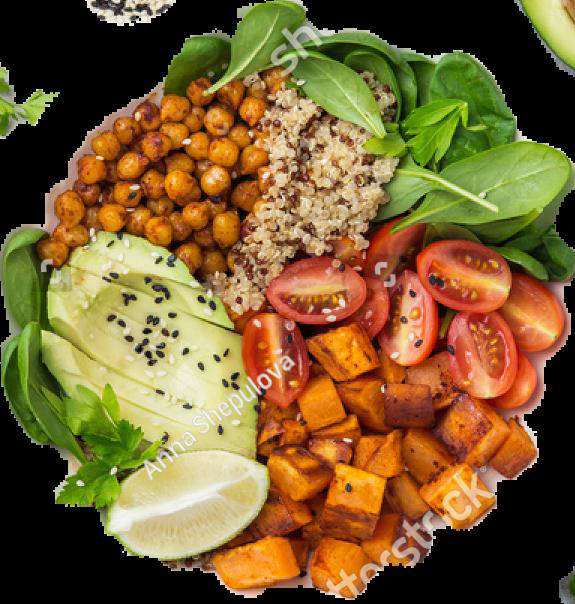

In [165]:
get_image_from_url(urls[2])

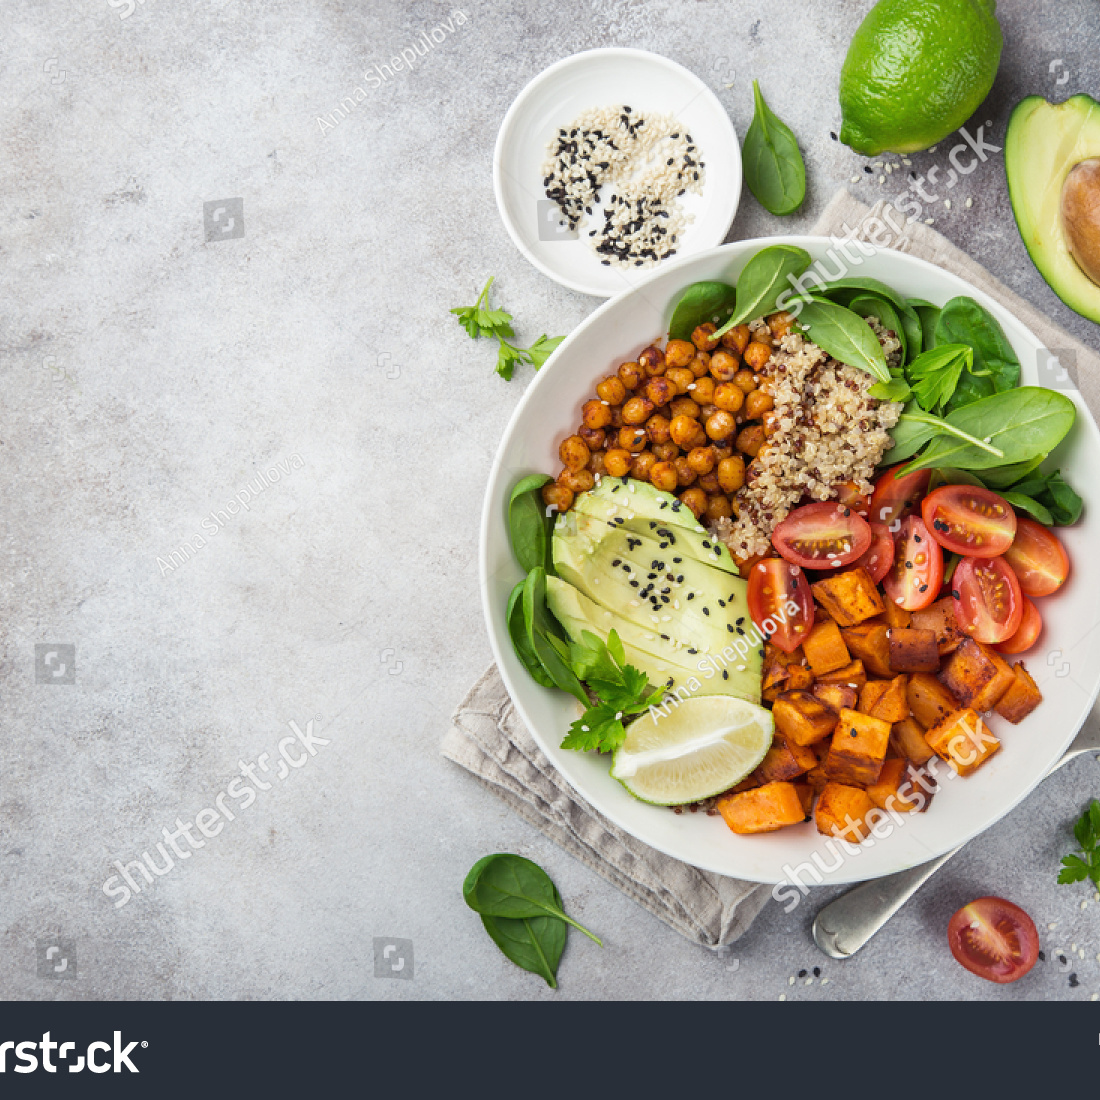

In [159]:
image

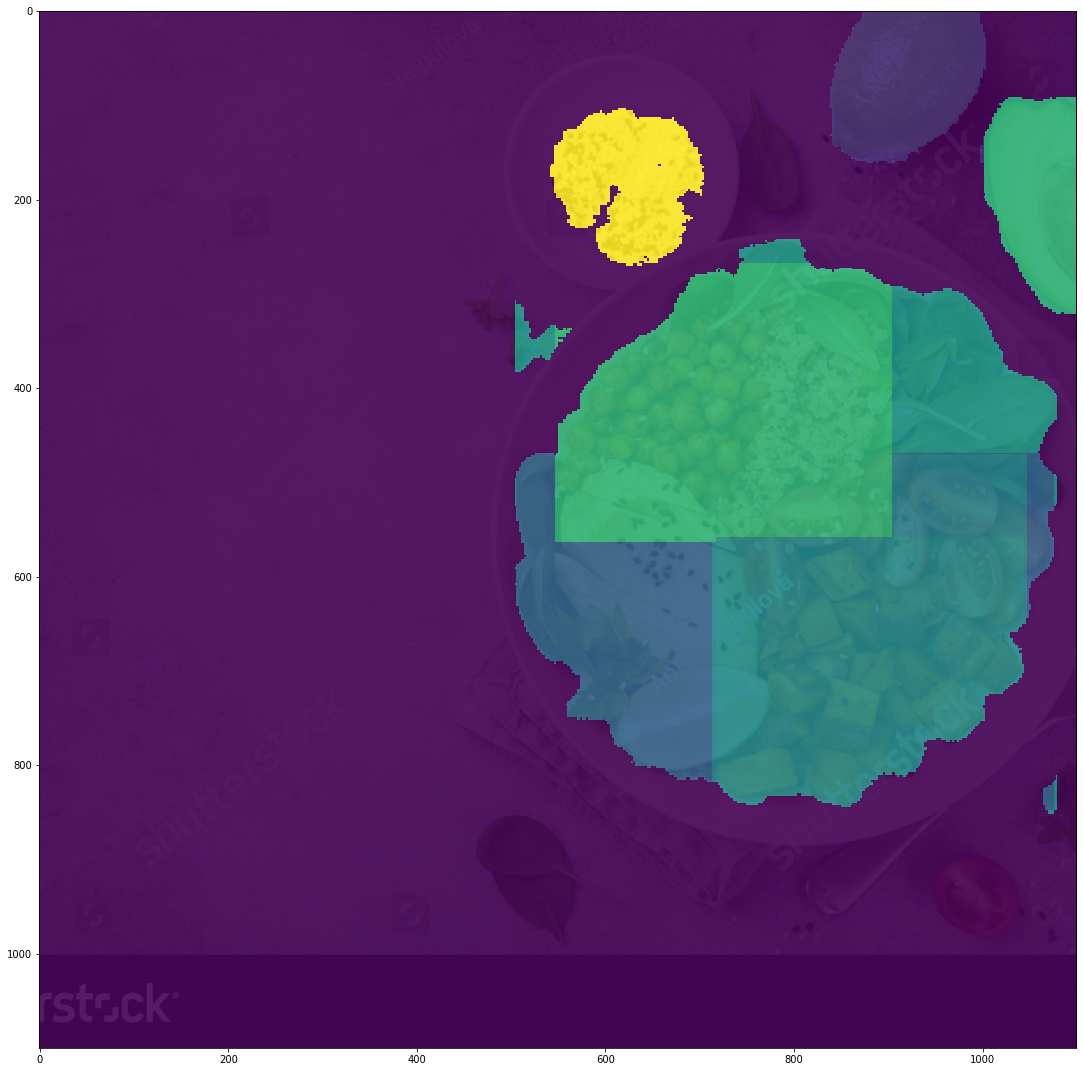

In [160]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=0.9)